In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [38]:
# Simulation parameters
NUM_YEARS = 10  # 2025-2035
NUM_PARCELS = 1000  # Simplified from original
NUM_PEOPLE = 1500  # Simplified from original
NUM_REALIZATIONS = 100  # Reduced from original for faster execution

# Updated neighborhood characteristics (average for Toronto)
AVG_LAND_VALUE = 1070100  # Updated average land value in CAD
AVG_IMPROVEMENT_VALUE = 642300  # Updated average improvement (structure) value in CAD
ZONING_TYPES = {
    'single_family': {'density': 0.5, 'probability': 0.7},  # Single family homes (R1)
    'multi_family': {'density': 1.25, 'probability': 0.2},  # Low-rise multi-family (R2)
    'mixed_use': {'density': 2.5, 'probability': 0.1}       # Mid-rise mixed use (R4)
}

# Updated policy scenarios
SCENARIOS = {
    'baseline': {
        'description': 'Current zoning policies remain unchanged',
        'interest_rate': 0.0387,  # Updated to 3.87% mortgage rate
        'property_tax_rate': 0.0065,  # 0.65% property tax
        'upzoning_multiplier': {
            'single_family': 1.0,  # No change
            'multi_family': 1.0,   # No change
            'mixed_use': 1.0       # No change
        }
    },
    'moderate_upzoning': {
        'description': 'Moderate relaxation of zoning restrictions',
        'interest_rate': 0.0387,  # Same as baseline
        'property_tax_rate': 0.0065,  # Same as baseline
        'upzoning_multiplier': {
            'single_family': 1.5,  # 50% increase in allowed density
            'multi_family': 1.3,   # 30% increase in allowed density
            'mixed_use': 1.2       # 20% increase in allowed density
        }
    },
    'greater_upzoning': {
        'description': 'Significant relaxation of zoning restrictions',
        'interest_rate': 0.0387,  # Same as baseline
        'property_tax_rate': 0.0065,  # Same as baseline
        'upzoning_multiplier': {
            'single_family': 2.0,  # 100% increase in allowed density
            'multi_family': 1.6,   # 60% increase in allowed density
            'mixed_use': 1.4       # 40% increase in allowed density
        }
    }
}

# Updated economic parameters
ECONOMIC_PARAMS = {
    'inflation_rate': 0.02,  # 2% annual inflation (Bank of Canada target)
    'wage_growth_rate': 0.025,  # 2.5% annual wage growth
    'market_sentiment': 0.52,  # Updated market sentiment (neutral leaning positive)
    'price_elasticity': -0.35  # Updated price elasticity of demand
}

# Updated buyer parameters
BUYER_PARAMS = {
    'avg_income': 98200,  # Updated average income in CAD
    'income_std_dev': 30000,  # Standard deviation of income
    'savings_rate': 0.117,  # Updated savings rate to 11.7%
    'max_price_to_income': 4.8,  # Updated maximum price-to-income ratio
    'down_payment_percent': 0.183  # Updated to 18.3% down payment
}

In [39]:
# Simplified ParcelAgent class
class ParcelAgent:
    def __init__(self, id, zoning_type, density_allowed):
        self.id = id
        self.zoning_type = zoning_type
        self.density_allowed = density_allowed
        self.land_value = np.random.normal(AVG_LAND_VALUE, AVG_LAND_VALUE * 0.3)
        self.improvement_value = np.random.normal(AVG_IMPROVEMENT_VALUE, AVG_IMPROVEMENT_VALUE * 0.3)
        self.owner = None
        self.for_sale = False
        self.units = 1  # Start with one unit per parcel
        self.max_units = max(1, int(self.density_allowed))
        
    def total_value(self):
        return self.land_value + self.improvement_value
    
    def market_price(self, market_sentiment):
        # Market price includes a sentiment factor
        sentiment_factor = 0.8 + (market_sentiment * 0.4)  # Range from 0.8 to 1.2
        return self.total_value() * sentiment_factor
    
    def update_values(self, inflation_rate):
        # Update land and improvement values based on inflation
        self.land_value *= (1 + inflation_rate)
        self.improvement_value *= (1 + inflation_rate)
    
    def can_redevelop(self, interest_rate, market_sentiment):
        # Check if redevelopment is economically viable
        if self.units >= self.max_units:
            return False
        
        current_value = self.total_value()
        potential_units = self.max_units
        
        # Simple redevelopment economics
        construction_cost_per_unit = 400000 * (1 + interest_rate/2)
        new_improvement_value = potential_units * construction_cost_per_unit
        
        # Expected market value after redevelopment
        expected_market_value = (self.land_value + new_improvement_value) * (0.8 + (market_sentiment * 0.4))
        
        # Redevelop if expected value is significantly higher than current value
        return expected_market_value > current_value * 1.3
    
    def redevelop(self):
        # Increase units up to maximum allowed
        old_units = self.units
        self.units = min(self.units + 1, self.max_units)
        
        # Update improvement value based on new units
        self.improvement_value *= (self.units / old_units)
        return self.units - old_units  # Return number of new units created

# Simplified PeopleAgent class
class PeopleAgent:
    def __init__(self, id):
        self.id = id
        self.income = max(30000, np.random.normal(BUYER_PARAMS['avg_income'], BUYER_PARAMS['income_std_dev']))
        self.savings = self.income * BUYER_PARAMS['savings_rate'] * np.random.uniform(1, 5)
        self.role = 'renter'  # Start as renter
        self.property_owned = None
        
    def update_income(self, wage_growth_rate):
        self.income *= (1 + wage_growth_rate)
        self.savings += self.income * BUYER_PARAMS['savings_rate']

    def housing_budget(self, interest_rate):
        # Calculate housing budget based on income and interest rate
        max_price = self.income * BUYER_PARAMS['max_price_to_income']
        
        # Adjust for interest rate impact
        interest_factor = 1 - ((interest_rate - 0.05) * 5)  # 5% is baseline
        max_price *= interest_factor
        
        # Check if down payment is sufficient
        if self.savings >= max_price * BUYER_PARAMS['down_payment_percent']:
            return max_price
        else:
            # Limited by down payment
            return self.savings / BUYER_PARAMS['down_payment_percent']

    def can_afford(self, price, interest_rate):
        return self.housing_budget(interest_rate) >= price and self.savings >= price * BUYER_PARAMS['down_payment_percent']

    def buy_property(self, property):
        self.role = 'homeowner'
        self.property_owned = property
        property.owner = self
        self.savings -= property.market_price(0.5) * BUYER_PARAMS['down_payment_percent']  # Pay down payment


In [40]:

# Simplified Toronto Housing Model
class TorontoHousingModel:
    def __init__(self, scenario_name):
        self.scenario = SCENARIOS[scenario_name]
        self.year = 2025
        self.parcels = []
        self.people = []
        self.metrics = {
            'years': [],
            'median_price': [],
            'mean_price': [],
            'price_to_income_ratio': [],
            'sales_volume': [],
            'new_construction': [],
            'interest_rate': []
        }
        
        # Initialize economic conditions
        self.interest_rate = self.scenario['interest_rate']
        self.inflation_rate = ECONOMIC_PARAMS['inflation_rate']
        self.wage_growth_rate = ECONOMIC_PARAMS['wage_growth_rate']
        self.market_sentiment = ECONOMIC_PARAMS['market_sentiment']
        
        # Initialize agents
        self.initialize_agents()
        
    def initialize_agents(self):
        # Create parcel agents
        for i in range(NUM_PARCELS):
            # Randomly select zoning type based on probabilities
            zoning_type = np.random.choice(
                list(ZONING_TYPES.keys()),
                p=[ZONING_TYPES[z]['probability'] for z in ZONING_TYPES.keys()]
            )
            
            # Calculate density allowed based on zoning type and scenario
            base_density = ZONING_TYPES[zoning_type]['density']
            upzoning_multiplier = self.scenario['upzoning_multiplier'][zoning_type]
            density_allowed = base_density * upzoning_multiplier
            
            # Create parcel
            parcel = ParcelAgent(i, zoning_type, density_allowed)
            self.parcels.append(parcel)
        
        # Create people agents
        for i in range(NUM_PEOPLE):
            person = PeopleAgent(i)
            self.people.append(person)
        
        # Assign initial properties to some people
        renters = [p for p in self.people if p.role == 'renter']
        for parcel in self.parcels:
            if not renters:
                break
            
            # Find a renter who can afford this property
            for i, renter in enumerate(renters):
                if renter.can_afford(parcel.market_price(self.market_sentiment), self.interest_rate):
                    renter.buy_property(parcel)
                    renters.pop(i)
                    break
    
    def update_market_sentiment(self):
        # Update market sentiment based on economic factors
        interest_effect = -0.2 * (self.interest_rate - 0.05) / 0.05  # Negative effect of higher rates
        inflation_effect = -0.1 * (self.inflation_rate - 0.02) / 0.02  # Negative effect of higher inflation
        
        # Random market sentiment shift
        random_shift = np.random.normal(0, 0.05)
        
        # Update sentiment with mean reversion
        self.market_sentiment += interest_effect + inflation_effect + random_shift
        self.market_sentiment = 0.2 + 0.6 * self.market_sentiment  # Mean reversion to 0.5
        self.market_sentiment = max(0.1, min(0.9, self.market_sentiment))  # Bound between 0.1 and 0.9
    
    def update_economic_conditions(self):
        # Simple random walk for economic conditions with mean reversion
        
        # Interest rate update
        interest_rate_shift = np.random.normal(0, 0.002)
        self.interest_rate += interest_rate_shift
        self.interest_rate = self.scenario['interest_rate'] + 0.7 * (self.interest_rate - self.scenario['interest_rate'])
        self.interest_rate = max(0.02, min(0.08, self.interest_rate))
        
        # Inflation rate update
        inflation_shift = np.random.normal(0, 0.002)
        self.inflation_rate += inflation_shift
        self.inflation_rate = ECONOMIC_PARAMS['inflation_rate'] + 0.7 * (self.inflation_rate - ECONOMIC_PARAMS['inflation_rate'])
        self.inflation_rate = max(0.01, min(0.04, self.inflation_rate))
        
        # Wage growth update
        wage_growth_shift = np.random.normal(0, 0.001)
        self.wage_growth_rate += wage_growth_shift
        self.wage_growth_rate = ECONOMIC_PARAMS['wage_growth_rate'] + 0.7 * (self.wage_growth_rate - ECONOMIC_PARAMS['wage_growth_rate'])
        self.wage_growth_rate = max(0.01, min(0.04, self.wage_growth_rate))
    
    def process_sales(self):
        # Determine which properties are for sale
        for parcel in self.parcels:
            # Random chance of property going for sale
            if parcel.owner and np.random.random() < 0.05:  # 5% chance
                parcel.for_sale = True
        
        # Process sales
        sales_count = 0
        for parcel in self.parcels:
            if parcel.for_sale:
                # Find potential buyers
                potential_buyers = [p for p in self.people if p.role == 'renter' and 
                                   p.can_afford(parcel.market_price(self.market_sentiment), self.interest_rate)]
                
                if potential_buyers:
                    # Sort by budget (highest first)
                    potential_buyers.sort(key=lambda x: x.housing_budget(self.interest_rate), reverse=True)
                    
                    # Sell to highest bidder
                    buyer = potential_buyers[0]
                    buyer.buy_property(parcel)
                    parcel.for_sale = False
                    sales_count += 1
        
        return sales_count
    
    def process_redevelopment(self):
        # Process redevelopment of parcels
        new_units = 0
        for parcel in self.parcels:
            if parcel.can_redevelop(self.interest_rate, self.market_sentiment):
                new_units += parcel.redevelop()
        
        return new_units
    
    def update_metrics(self):
        # Calculate and store metrics for the current year
        self.metrics['years'].append(self.year)
        
        # Calculate prices
        prices = [p.market_price(self.market_sentiment) for p in self.parcels]
        self.metrics['median_price'].append(np.median(prices))
        self.metrics['mean_price'].append(np.mean(prices))
        
        # Calculate price to income ratio
        median_income = np.median([p.income for p in self.people])
        self.metrics['price_to_income_ratio'].append(np.median(prices) / median_income)
        
        # Store other metrics
        self.metrics['interest_rate'].append(self.interest_rate)
    
    def step(self):
        # Run one year of the simulation
        self.year += 1
        
        # Update economic conditions
        self.update_economic_conditions()
        self.update_market_sentiment()
        
        # Update agents
        for person in self.people:
            person.update_income(self.wage_growth_rate)
        
        for parcel in self.parcels:
            parcel.update_values(self.inflation_rate)
        
        # Process sales
        sales_volume = self.process_sales()
        self.metrics['sales_volume'].append(sales_volume)
        
        # Process redevelopment
        new_construction = self.process_redevelopment()
        self.metrics['new_construction'].append(new_construction)
        
        # Update metrics
        self.update_metrics()
    
    def run(self):
        # Run the simulation for NUM_YEARS
        for _ in range(NUM_YEARS):
            self.step()
        
        return self.metrics


In [41]:

# Function to run multiple realizations of a scenario
def run_scenario_simulations(scenario_name):
    print(f"Running {scenario_name} scenario simulations...")
    
    # Initialize aggregated metrics
    aggregated_metrics = {
        'years': list(range(2025, 2025 + NUM_YEARS + 1)),
        'median_price_median': [],
        'median_price_10th': [],
        'median_price_90th': [],
        'price_to_income_ratio_median': [],
        'price_to_income_ratio_10th': [],
        'price_to_income_ratio_90th': [],
        'new_construction_cumulative': []
    }
    
    # Store results from all realizations
    all_results = []
    
    # Run multiple realizations
    for _ in tqdm(range(NUM_REALIZATIONS)):
        model = TorontoHousingModel(scenario_name)
        metrics = model.run()
        all_results.append(metrics)
    
    # Aggregate results
    for year_idx, year in enumerate(aggregated_metrics['years']):
        # Skip the first year (2025) as it's just initialization
        if year_idx == 0:
            aggregated_metrics['median_price_median'].append(None)
            aggregated_metrics['median_price_10th'].append(None)
            aggregated_metrics['median_price_90th'].append(None)
            aggregated_metrics['price_to_income_ratio_median'].append(None)
            aggregated_metrics['price_to_income_ratio_10th'].append(None)
            aggregated_metrics['price_to_income_ratio_90th'].append(None)
            aggregated_metrics['new_construction_cumulative'].append(0)
            continue
        
        # Collect metrics across all realizations for this year
        year_prices = [result['median_price'][year_idx-1] for result in all_results]
        year_price_to_income = [result['price_to_income_ratio'][year_idx-1] for result in all_results]
        
        # Calculate statistics
        aggregated_metrics['median_price_median'].append(np.median(year_prices))
        aggregated_metrics['median_price_10th'].append(np.percentile(year_prices, 10))
        aggregated_metrics['median_price_90th'].append(np.percentile(year_prices, 90))
        
        aggregated_metrics['price_to_income_ratio_median'].append(np.median(year_price_to_income))
        aggregated_metrics['price_to_income_ratio_10th'].append(np.percentile(year_price_to_income, 10))
        aggregated_metrics['price_to_income_ratio_90th'].append(np.percentile(year_price_to_income, 90))
        
        # Calculate cumulative new construction
        if year_idx == 1:
            aggregated_metrics['new_construction_cumulative'].append(
                np.mean([result['new_construction'][year_idx-1] for result in all_results])
            )
        else:
            aggregated_metrics['new_construction_cumulative'].append(
                aggregated_metrics['new_construction_cumulative'][-1] + 
                np.mean([result['new_construction'][year_idx-1] for result in all_results])
            )
    
    return aggregated_metrics


In [42]:
# Run simulations for each scenario
baseline_results = run_scenario_simulations('baseline')

Running baseline scenario simulations...


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [21]:
moderate_upzoning_results = run_scenario_simulations('moderate_upzoning')

Running moderate_upzoning scenario simulations...


  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]

In [22]:
greater_upzoning_results = run_scenario_simulations('greater_upzoning')

Running greater_upzoning scenario simulations...


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [23]:

# Generate summary report for 2035 (final year)
final_year_index = -1
print("\nSummary Report for 2035:")
print("------------------------")
print(f"Baseline Scenario:")
print(f"  Median House Price: ${baseline_results['median_price_median'][final_year_index]/1000000:.2f}M")
print(f"  Price-to-Income Ratio: {baseline_results['price_to_income_ratio_median'][final_year_index]:.2f}")
print(f"  Cumulative New Construction: {baseline_results['new_construction_cumulative'][final_year_index]:.0f} units")
print()
print(f"Moderate Upzoning Scenario:")
print(f"  Median House Price: ${moderate_upzoning_results['median_price_median'][final_year_index]/1000000:.2f}M")
print(f"  Price-to-Income Ratio: {moderate_upzoning_results['price_to_income_ratio_median'][final_year_index]:.2f}")
print(f"  Cumulative New Construction: {moderate_upzoning_results['new_construction_cumulative'][final_year_index]:.0f} units")
print()
print(f"Greater Upzoning Scenario:")
print(f"  Median House Price: ${greater_upzoning_results['median_price_median'][final_year_index]/1000000:.2f}M")
print(f"  Price-to-Income Ratio: {greater_upzoning_results['price_to_income_ratio_median'][final_year_index]:.2f}")
print(f"  Cumulative New Construction: {greater_upzoning_results['new_construction_cumulative'][final_year_index]:.0f} units")



Summary Report for 2035:
------------------------
Baseline Scenario:
  Median House Price: $2.16M
  Price-to-Income Ratio: 17.01
  Cumulative New Construction: 13 units

Moderate Upzoning Scenario:
  Median House Price: $2.22M
  Price-to-Income Ratio: 17.44
  Cumulative New Construction: 66 units

Greater Upzoning Scenario:
  Median House Price: $2.22M
  Price-to-Income Ratio: 17.73
  Cumulative New Construction: 103 units


In [24]:

# Plot price-to-income ratio for all scenarios
def plot_affordability_comparison():
    years = baseline_results['years'][1:]  # Skip initialization year
    
    plt.figure(figsize=(12, 8))
    
    # Baseline scenario
    plt.plot(years, baseline_results['price_to_income_ratio_median'][1:], 'b-', label='Baseline Scenario')
    plt.fill_between(years, 
                     baseline_results['price_to_income_ratio_10th'][1:], 
                     baseline_results['price_to_income_ratio_90th'][1:], 
                     alpha=0.2, color='blue')
    
    # Moderate upzoning scenario
    plt.plot(years, moderate_upzoning_results['price_to_income_ratio_median'][1:], 'g-', label='Moderate Upzoning')
    plt.fill_between(years, 
                     moderate_upzoning_results['price_to_income_ratio_10th'][1:], 
                     moderate_upzoning_results['price_to_income_ratio_90th'][1:], 
                     alpha=0.2, color='green')
    
    # Greater upzoning scenario
    plt.plot(years, greater_upzoning_results['price_to_income_ratio_median'][1:], 'r-', label='Greater Upzoning')
    plt.fill_between(years, 
                     greater_upzoning_results['price_to_income_ratio_10th'][1:], 
                     greater_upzoning_results['price_to_income_ratio_90th'][1:], 
                     alpha=0.2, color='red')
    
    plt.title('Toronto Housing Affordability Comparison (2025-2035)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Price to Income Ratio', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add a horizontal line for reference (e.g., 5.0 is often considered a threshold for affordability)
    plt.axhline(y=5.0, color='k', linestyle='--', alpha=0.7, label='Affordability Threshold')
    
    plt.tight_layout()
    plt.show()

# Plot new construction for all scenarios
def plot_construction_comparison():
    years = baseline_results['years'][1:]  # Skip initialization year
    
    plt.figure(figsize=(12, 8))
    
    # Plot cumulative new construction
    plt.plot(years, baseline_results['new_construction_cumulative'][1:], 'b-', label='Baseline Scenario')
    plt.plot(years, moderate_upzoning_results['new_construction_cumulative'][1:], 'g-', label='Moderate Upzoning')
    plt.plot(years, greater_upzoning_results['new_construction_cumulative'][1:], 'r-', label='Greater Upzoning')
    
    plt.title('Cumulative New Housing Construction (2025-2035)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Cumulative New Units', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()


Generating affordability comparison visualization...


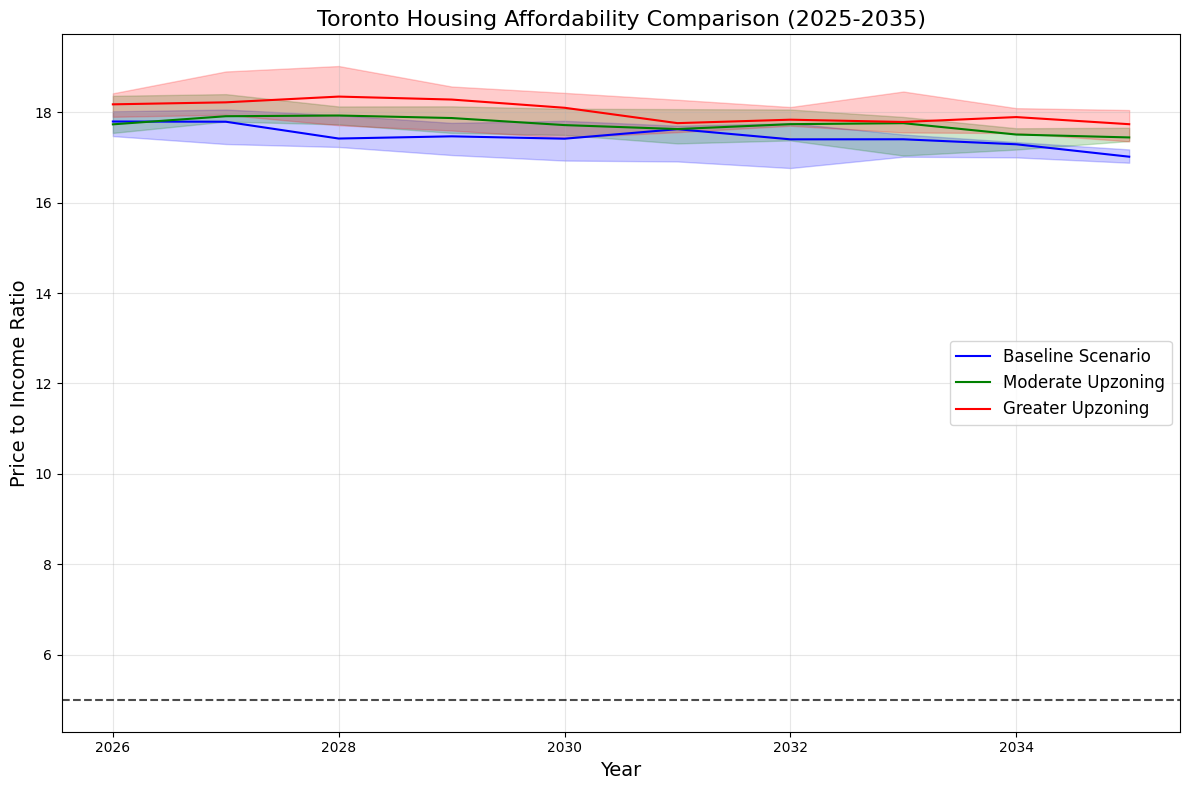

In [ ]:
# Generate visualizations
print("\nGenerating affordability comparison visualization...")
plot_affordability_comparison()